# Imports

In [1]:
import numpy as np
import pandas as pd
import math
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
from IPython.display import display
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)
pd.set_option('display.colheader_justify', 'center')
pd.set_option('display.precision', 3)
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import SGDClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report
from tensorflow.keras.utils import plot_model
from IPython.display import Image

# Fetching data from imdb

In [2]:
def data_fetch():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.imdb.load_data()

    word_index = tf.keras.datasets.imdb.get_word_index()
    index2word = dict((i + 3, word) for (word, i) in word_index.items())
    index2word[0] = '[pad]' #padding
    index2word[1] = '[bos]' #begin of sentence
    index2word[2] = '[oov]' # out of vocabulary
    x_train = np.array([' '.join([index2word[idx] for idx in text]) for text in x_train])
    x_test = np.array([' '.join([index2word[idx] for idx in text]) for text in x_test])
    return x_train, y_train, x_test, y_test

# Vectorizing examples

In [3]:
def vectorize_examples(vocabulary, x_train):
    binary_vectorizer = CountVectorizer(binary=True, vocabulary=vocabulary.keys())
    x_train_binary = binary_vectorizer.fit_transform(x_train)
    x_train_binary = x_train_binary.toarray()
    return x_train_binary

## Information Gain

In [4]:
def calculate_ig(classes_vector, feature):
        classes = set(classes_vector)
        HC = 0
        for c in classes:
            PC = list(classes_vector).count(c) / len(classes_vector)  # P(C=c)
            HC += - PC * math.log(PC, 2)  # H(C)

        feature_values = set(feature)  # 0 or 1 in this example
        HC_feature = 0
        for value in feature_values:
            # pf --> P(X=x)
            pf = list(feature).count(value) / len(feature)  # count occurences of value 
            indices = [i for i in range(len(feature)) if feature[i] == value]  # rows (examples) that have X=x

            classes_of_feat = [classes_vector[i] for i in indices]  # category of examples listed in indices above
            for c in classes:
                # pcf --> P(C=c|X=x)
                pcf = classes_of_feat.count(c) / len(classes_of_feat)  # given X=x, count C
                if pcf != 0: 
                    # - P(X=x) * P(C=c|X=x) * log2(P(C=c|X=x))
                    temp_H = - pf * pcf * math.log(pcf, 2)
                    # sum for all values of C (class) and X (values of specific feature)
                    HC_feature += temp_H

        ig = HC - HC_feature
        return ig

# Vocabulary

In [5]:
def create_vocabulary(x_train,y_train, n, k, m, l):
    words_frequency_dict = dict()

    for review in x_train:
        distinct_words = set(review.split())

        for word in distinct_words:
            if word in words_frequency_dict:
                words_frequency_dict[word] += 1
            else:
                words_frequency_dict[word] = 1
    
    # Remove specific words from the dictionary
    for special_word in ['[bos]', '[pad]', '[oov]']:
        words_frequency_dict.pop(special_word, None)
   


    # Sort words based on their frequency in descending order
    remaining_words = sorted(words_frequency_dict.items(), key=lambda x: x[1], reverse=True)
    # Exclude the top n and bottom k words
    remaining_words = remaining_words[n:-k] 
    # Convert remaining_words back into a dictionary
    remaining_words = dict(remaining_words)

    # Create a new dictionary which shows the IG
    IG_dict = dict()
    x_train_binary = vectorize_examples(remaining_words, x_train)
    

    for i in tqdm(range(len(remaining_words))):
        # word = [example[i] for example in x_train_binary.T]
        word = [example[i] for example in x_train_binary]
        IG_dict[list(remaining_words.keys())[i]] = calculate_ig(y_train, word)

    # Sort words based on Information Gain in ascending order
    remaining_words = sorted(IG_dict.items(), key=lambda x: x[1], reverse=True)
    # Select the top l words
    remaining_words = remaining_words[:l] 
    # Convert remaining_words back into a dictionary
    remaining_words_dict = dict(remaining_words)

    return remaining_words_dict


# Naive Bayes 

In [6]:
class NaiveBayesCustom():
    def __init__(self):
        self.class0_prob = None
        self.class1_prob = None
        self.feature_probs = None

    def fit(self,x_train_binary, y_train):

        # Calculate prior probabilites P(C=0) and P(C=1)
        total_samples = len(y_train)
        class0_samples = np.sum(y_train == 0)
        class1_samples = total_samples - class0_samples

        class0_prob = class0_samples / total_samples
        class1_prob = class1_samples / total_samples

        self.class0_prob = class0_prob
        self.class1_prob = class1_prob

        # Calculate the likelihood
        self.feature_probs = np.zeros((2,x_train_binary.shape[1])) # 2 (class 0 , class 1) * num of features 

        # Select samples belonging to class 0,1
        X_0 = []
        X_1 = []  #alliws np.array

        for i in range(x_train_binary.shape[1]):
            if y_train[i] == 0:
                X_0.append(x_train_binary[i])
            else:
                X_1.append(x_train_binary[i])
            
        # Convert lists to numpy arrays
        X_0 = np.array(X_0)
        X_1 = np.array(X_1)

        # Calculate the probability of each feature being 0 given the class
        self.feature_probs[0] = (X_0.sum(axis=0) + 1) / (len(X_0) + 2)   # +1 and +2 for Laplace 
        # Calculate the probability of each feature being 1 given the class
        self.feature_probs[1] = (X_1.sum(axis=0) + 1) / (len(X_1) + 2)    # +1 and +2 for Laplace 
        

    def predict(self, x_test_binary):
        
        sum_prob0=0
        sum_prob1=0

        num_features = x_test_binary.shape[1]
        y_predict =[]

        # Calculating P(C=1 | x_test_binary) and P(C=0 | x_test_binary)
        
        for x_test in x_test_binary:
            # sum_prob0 = sum( math.log(self.feature_probs[0][i]) if x_test[i] == 1 else  math.log(1-self.feature_probs[0][i]) for i in range(num_features) )
            # sum_prob1 = sum( math.log(self.feature_probs[1][i]) if x_test[i] == 1 else  math.log(1-self.feature_probs[1][i]) for i in range(num_features) )

            # sum_prob1 = math.log(self.class1_prob) + sum_prob1
            # sum_prob0 = math.log(self.class0_prob) + sum_prob0

            feature_prob_0 = np.log(self.feature_probs[0])
            feature_prob_1 = np.log(self.feature_probs[1])
            feature_prob_0 = np.sum(feature_prob_0 * x_test + np.log(1 - np.exp(feature_prob_0) * x_test), axis=0)
            feature_prob_1 = np.sum(feature_prob_1 * x_test + np.log(1 - np.exp(feature_prob_1) * x_test), axis=0)
            sum_prob0 = np.log(self.class0_prob) + feature_prob_0
            sum_prob1 = np.log(self.class1_prob) +feature_prob_1

            if (sum_prob1 > sum_prob0):
                y_predict.append(1)
            elif(sum_prob1 < sum_prob0):
                y_predict.append(0)
            else:
                y_predict.append(1 if self.class1_prob > self.class0_prob else 0)


        return y_predict


# Logistic Regression

In [7]:
class CustomLogisticRegression():
    def __init__(self, regularizator, learning_rate, n_iterations):
        self.regularizator = regularizator
        self.learning_rate = learning_rate
        self.num_iterations = n_iterations
        self.weights = None

    def sigmoid(self, t):
        return 1 / (1 + np.exp(-t))
    
    def fit(self,x_train_binary, y_train):
        """
        to stop the while loop, we need to calculate the s. this is the accuracy score. 
        to do so, we need to split our data into trainig and testing so every time 
        we can check the accuracy score.

        epoch : while the accuracy score is not acceptable, start a new epoch iterating again
                all the examples  (_x_train)
        """
        _x_train, _x_valuation, _y_train, _y_valuation = train_test_split(x_train_binary, y_train, test_size=0.2)
        
        num_of_features = _x_train.shape[1]
        num_of_examples = len(_y_train)

        """ 
            w0*x0 -> x0 = 1 (bias term)                                                                        # or  _x_train = np.insert(_x_train, 0, np.ones(num_of_examples), axis =1)
            Concatenate a column of ones to the left side of the entire array
        """
        _x_train = np.c_[np.ones(num_of_examples), _x_train]
        best_s=0

        # step 1 : start with random weights
        self.weights = np.random.rand(1, num_of_features+1) # num_of_features+1 beacuse we have the w0 (bias term)

        iteration = 1 # epoch
        unchanged_epochs = 0
        best_iteration = 0
        s = 0
        while ( iteration<=self.num_iterations ):
            # step 2 :  
            #---------------SHUFFLE-------------
            # Create a permutation index
            permutation_index = np.random.permutation(len(_y_train))
            # Use the permutation index to shuffle both arrays
            shuffled_y_train = _y_train[permutation_index]
            shuffled_x_train_binary = _x_train[permutation_index]
            #---------------END SHUFFLE-------------

            # maximizing l(w) 
            for i in range (num_of_examples):
                # step 3: calculating li(w) for every example
                """ 
                The np.dot function is used for matrix multiplication or dot product 
                between arrays. It calculates the sum of the element-wise products
                of two arrays.
                """
                t = np.dot(self.weights, shuffled_x_train_binary[i]) # t = w*x
                p_c_positive = self.sigmoid(t) # P(c+|xi)

                l = (shuffled_y_train[i]-p_c_positive)*shuffled_x_train_binary[i] # (yi - P(c+|xi)) * xi
              
                #step 5: inform weights
                self.weights =(1-2*self.learning_rate*self.regularizator) * self.weights + self.learning_rate * l       
                # step 6: move to next example 

            

            # checkig the accuracy 
            #step 7 :
            s = accuracy_score(_y_valuation, self.predict(_x_valuation))
            if s > best_s:
                #best_iteration = iteration 
                best_s = s
                best_weights = self.weights
                unchanged_epochs = 0
            else:
                iteration += 1 # increasing number of epoch
                unchanged_epochs +=1

            if unchanged_epochs == 33: # ανεχομαστε μεχρι 33 εποχες χωρις να εχουν βελτιωωθει γιατι μπορει να βελτιωθει η ακριβεια μετα απο καποιες εποχες. Αν οχι, επιστρεφουμε την καλυτερη
                self.weights = best_weights
                break
            
            # iteration += 1 #increasing number of epochs

        return _x_train, _y_train

    def predict(self, x_test_binary):
        num_of_examples = x_test_binary.shape[0]
        x_test = np.c_[np.ones(num_of_examples), x_test_binary]     #insert 1 for w0

        y_pred = list()
        for example in x_test:
            sign = np.dot(self.weights, example)
            # apofasi katataksis diafaneia 4 lecture 18
            if sign > 0 : 
                y_pred.append(1)
            else:
                y_pred.append(0)

        return np.array(y_pred)


# Finding Best Regularizer

In [8]:
import random

random.seed(42)

def find_regularizer(_x_train, _x_val, _y_train, _y_val):
    # reg should be in range (0,1)
    best_classifier = None
    best_acc = 0
    n_iters_unchanged = 1
    regularizer = 0
    while regularizer <= 1:
        clr = CustomLogisticRegression(regularizer, 0.001, 100)
        clr.fit(_x_train, _y_train)
        _y_pred_val = clr.predict(_x_val)                 
        acc = accuracy_score(_y_val, _y_pred_val)
        print("\tRegularizer: ", regularizer, "\tDevalopment Accuracy Score: ", acc)
        if acc > best_acc:
            best_acc = acc
            best_regularizer = regularizer
            best_classifier = clr
            n_iters_unchanged = 0
        else:
            n_iters_unchanged += 1

        if n_iters_unchanged == 5:
            break
        regularizer += 0.0000000000000001 
        
    return best_classifier, best_regularizer, best_acc

In [9]:
def find_learning_rate(_x_train, _x_val, _y_train, _y_val, best_regularizer):
    # learning rate should be in range (0,1)
    best_classifier = None
    best_acc = 0
    n_iters_unchanged = 1
    learning_rate = 0
    while learning_rate <= 1 :
        clr = CustomLogisticRegression(best_regularizer, learning_rate, 200)
        clr.fit(_x_train, _y_train)
        _y_pred_val = clr.predict(_x_val)                 
        acc = accuracy_score(_y_val, _y_pred_val)
        print("\tLearning rate: ", learning_rate, "\tDevalopment Accuracy Score: ", acc)
        if acc > best_acc:
            best_acc = acc
            best_classifier = clr
            best_learning_rate = learning_rate
            n_iters_unchanged = 0
        else:
            n_iters_unchanged += 1

        if n_iters_unchanged == 5:
            break
        learning_rate += 0.001 
        
    return best_classifier, best_learning_rate

# Curves

In [63]:
def learning_curves(predictor, x_train, y_train, x_test, y_test, n_splits, counter=1):
    step_size = len(x_train) // n_splits
    
    # Initialize lists to store metrics for each iteration
    training_accuracy_list, testing_accuracy_list = [], []
    training_precision_list, testing_precision_list = [], []
    training_recall_list, testing_recall_list = [], []
    training_f1_list, testing_f1_list = [], []

    for i in range(1, n_splits + 1):
        subset_x_train = x_train[:i * step_size]
        subset_y_train = y_train[:i * step_size]

        predictor.fit(subset_x_train, subset_y_train)

        train_predictions = predictor.predict(subset_x_train)
        test_predictions = predictor.predict(x_test)

        train_accuracy = np.mean(train_predictions == subset_y_train)
        test_accuracy = np.mean(test_predictions == y_test)

        train_precision = np.sum(train_predictions * subset_y_train) / np.sum(train_predictions)
        test_precision = np.sum(test_predictions * y_test) / np.sum(test_predictions)

        train_recall = np.sum(train_predictions * subset_y_train) / np.sum(subset_y_train)
        test_recall = np.sum(test_predictions * y_test) / np.sum(y_test)

        train_f1 = 2 * (train_precision * train_recall) / (train_precision + train_recall)
        test_f1 = 2 * (test_precision * test_recall) / (test_precision + test_recall)

        # Append metrics to lists
        training_accuracy_list.append(train_accuracy)
        testing_accuracy_list.append(test_accuracy)
        training_precision_list.append(train_precision)
        testing_precision_list.append(test_precision)
        training_recall_list.append(train_recall)
        testing_recall_list.append(test_recall)
        training_f1_list.append(train_f1)
        testing_f1_list.append(test_f1)

    # Plotting using the lists
    iterations = range(1, n_splits + 1)

    # Plot Accuracy
    plt.plot(iterations, training_accuracy_list, label='Training Set')
    plt.plot(iterations, testing_accuracy_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    if counter == 1:
        plt.title('Accuracy Learning Curve for Naive Bayes')
    else:
        plt.title('Accuracy Learning Curve for Logistic Regression')
    plt.show()

    # Plot Precision
    plt.plot(iterations, training_precision_list, label='Training Set')
    plt.plot(iterations, testing_precision_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Precision')
    plt.legend()
    if counter == 1:
        plt.title('Precision Learning Curve for Naive Bayes')
    else:
        plt.title('Precision Learning Curve for Logistic Regression')
    plt.show()

    # Plot Recall
    plt.plot(iterations, training_recall_list, label='Training Set')
    plt.plot(iterations, testing_recall_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Recall')
    plt.legend()
    if counter == 1:
        plt.title('Recall Learning Curve for Naive Bayes')
    else:
        plt.title('Recall Learning Curve for Logistic Regression')
    plt.show()

    # Plot F1 Score
    plt.plot(iterations, training_f1_list, label='Training Set')
    plt.plot(iterations, testing_f1_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('F1 Score')
    plt.legend()
    if counter == 1:
        plt.title('F1 Score Learning Curve for Naive Bayes')
    else:
        plt.title('F1 Score Learning Curve for Logistic Regression')
    plt.show()

    # Return the lists if needed
    return (
        training_accuracy_list, testing_accuracy_list,
        training_precision_list, testing_precision_list,
        training_recall_list, testing_recall_list,
        training_f1_list, testing_f1_list
    )

def learning_curve_for_biGRURNN(predictor, x_train, y_train, x_test, y_test, n_splits):
    step_size = len(x_train) // n_splits
    
    # Initialize lists to store metrics for each iteration
    training_accuracy_list, testing_accuracy_list = [], []
    training_precision_list, testing_precision_list = [], []
    training_recall_list, testing_recall_list = [], []
    training_f1_list, testing_f1_list = [], []

    # Initialize lists for reporting table
    splits = []

    # Use tqdm to display progress bar
    progress_bar = tqdm(total=n_splits, desc="Calculating Metrics", position=0)

    for i in range(1, n_splits + 1):
        subset_x_train = x_train[:i * step_size]
        subset_y_train = y_train[:i * step_size]

        predictor.fit(subset_x_train, subset_y_train)

        train_predictions = predictor.predict(subset_x_train)
        test_predictions = predictor.predict(x_test)

        # Calculate metrics
        train_accuracy = accuracy_score(subset_y_train, train_predictions)
        test_accuracy = accuracy_score(y_test, test_predictions)

        train_precision = precision_score(subset_y_train, train_predictions)
        test_precision = precision_score(y_test, test_predictions)

        train_recall = recall_score(subset_y_train, train_predictions)
        test_recall = recall_score(y_test, test_predictions)

        train_f1 = f1_score(subset_y_train, train_predictions)
        test_f1 = f1_score(y_test, test_predictions)

        # Append metrics to lists
        training_accuracy_list.append(train_accuracy)
        testing_accuracy_list.append(test_accuracy)
        training_precision_list.append(train_precision)
        testing_precision_list.append(test_precision)
        training_recall_list.append(train_recall)
        testing_recall_list.append(test_recall)
        training_f1_list.append(train_f1)
        testing_f1_list.append(test_f1)

        splits.append(len(subset_x_train))

        # Update progress bar
        progress_bar.update(1)

    # Close the progress bar
    progress_bar.close()

    # Create reporting table
    report_table = pd.DataFrame({
        'Train Size (%)': [x / len(x_train) * 100 for x in splits],
        'Accuracy Train': training_accuracy_list,
        'Accuracy Test': testing_accuracy_list,
        'Precision Train': training_precision_list,
        'Precision Test': testing_precision_list,
        'Recall Train': training_recall_list,
        'Recall Test': testing_recall_list,
        'F1 Train': training_f1_list,
        'F1 Test': testing_f1_list
    }).set_index('Train Size (%)')

    # Display reporting table
    display(report_table)

    # Plotting using the lists
    iterations = range(1, n_splits + 1)

    # Plot Accuracy
    plt.plot(iterations, training_accuracy_list, label='Training Set')
    plt.plot(iterations, testing_accuracy_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Learning Curve for biGRURNN')
    plt.show()

    # Plot Precision
    plt.plot(iterations, training_precision_list, label='Training Set')
    plt.plot(iterations, testing_precision_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Precision')
    plt.legend()
    plt.title('Precision Learning Curve for biGRURNN')
    plt.show()

    # Plot Recall
    plt.plot(iterations, training_recall_list, label='Training Set')
    plt.plot(iterations, testing_recall_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('Recall')
    plt.legend()
    plt.title('Recall Learning Curve for biGRURNN')
    plt.show()

    # Plot F1 Score
    plt.plot(iterations, training_f1_list, label='Training Set')
    plt.plot(iterations, testing_f1_list, label='Testing Set')
    plt.xlabel('Iterations')
    plt.ylabel('F1 Score')
    plt.legend()
    plt.title('F1 Score Learning Curve for biGRURNN')
    plt.show()

    # Return the reporting table
    return (training_accuracy_list, testing_accuracy_list,
        training_precision_list, testing_precision_list,
        training_recall_list, testing_recall_list,
        training_f1_list, testing_f1_list)

In [70]:
def loss_plot(history):
    kind = "loss"

    train = history.history[kind]
    val = history.history['val_' + kind]
    
    epochs = range(1, len(train)+1)
    plt.figure(figsize=(12,9))
    plt.plot(epochs, train, 'royalblue', label='Training ' + kind)
    plt.plot(epochs, val, 'red', label='Validation ' + kind)
    plt.title('Training and validation ' + kind) 
    plt.xlabel('Epochs')
    plt.ylabel(kind)
    plt.legend()
    plt.show()

# Make Comparisons Function

In [12]:
# Lists obtained from learning_curves function
train_sizes = [0.2, 0.4, 0.6, 0.8, 1.0]
def make_comparisons(nbc_metrics, nb_metrics, train_sizes, n_splits=5, counter=1):
    
    # Calculate the differences
    accuracy_train_diff = np.subtract(nbc_metrics[0], nb_metrics[0])
    accuracy_test_diff = np.subtract(nbc_metrics[1], nb_metrics[1])
    precision_train_diff = np.subtract(nbc_metrics[2], nb_metrics[2])
    precision_test_diff = np.subtract(nbc_metrics[3], nb_metrics[3])
    recall_train_diff = np.subtract(nbc_metrics[4], nb_metrics[4])
    recall_test_diff = np.subtract(nbc_metrics[5], nb_metrics[5])
    f1_score_train_diff = np.subtract(nbc_metrics[6], nb_metrics[6])
    f1_score_test_diff = np.subtract(nbc_metrics[7], nb_metrics[7])
    
    # Create a 2D array with the difference values
    diff_scores = np.array([
        accuracy_train_diff, accuracy_test_diff,
        precision_train_diff, precision_test_diff,
        recall_train_diff, recall_test_diff,
        f1_score_train_diff, f1_score_test_diff
    ])

    # Plot heatmap with differences only
    metrics_labels_diff = [
        'Accuracy Train Diff', 'Accuracy Test Diff',
        'Precision Train Diff', 'Precision Test Diff',
        'Recall Train Diff', 'Recall Test Diff',
        'F1-Score Train Diff', 'F1-Score Test Diff'
    ]

    sns.heatmap(diff_scores, annot=True, cmap='YlGnBu', fmt=".3f", xticklabels=train_sizes, yticklabels=metrics_labels_diff)
    if(counter == 1):
        plt.title('Differences in Performance Metrics at Different Train Sizes (NBC - BernoulliNB)')
    else:
        plt.title('Differences in Performance Metrics at Different Train Sizes (Custom Logistic Regression - sickit learn Logistic Regression )')
    plt.xlabel('Train Size (%)')
    plt.ylabel('Performance Metrics')
    plt.show()

# Training & Testing

In [13]:
x_train, y_train, x_test, y_test = data_fetch()
vocabulary = create_vocabulary(x_train,y_train, 50, 85000, 2500, 1000)
x_train_binary = vectorize_examples(vocabulary, x_train)
x_test_binary = vectorize_examples(vocabulary, x_test)

100%|██████████| 3026/3026 [00:34<00:00, 88.06it/s] 


# Training And Testing - Naive Bayes

                    # 1a. Running Custom Naive Bayes
                

In [14]:
nbc = NaiveBayesCustom()
nbc.fit(x_train_binary, y_train)
print("Custom Naive Bayes")
print("\t\tClassification Report at training:\n")
print(classification_report(y_train, nbc.predict(x_train_binary),zero_division=1))
print("\t\tClassification Report at testing:\n")
print(classification_report(y_test, nbc.predict(x_test_binary), zero_division=1))

Custom Naive Bayes
		Classification Report at training:

              precision    recall  f1-score   support

           0       0.82      0.88      0.85     12500
           1       0.87      0.81      0.84     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.84     25000
weighted avg       0.85      0.85      0.84     25000

		Classification Report at testing:

              precision    recall  f1-score   support

           0       0.81      0.88      0.85     12500
           1       0.87      0.80      0.83     12500

    accuracy                           0.84     25000
   macro avg       0.84      0.84      0.84     25000
weighted avg       0.84      0.84      0.84     25000



                    # 1b. Curves of Custom Naive Bayes

Calculating Metrics: 100%|██████████| 5/5 [00:06<00:00,  1.40s/it]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.856,0.84,0.881,0.868,0.831,0.802,0.855,0.834
40.0,0.850,0.84,0.875,0.869,0.820,0.801,0.847,0.834
60.0,0.848,0.84,0.873,0.869,0.815,0.801,0.843,0.833
80.0,0.845,0.84,0.870,0.869,0.812,0.800,0.840,0.833
100.0,0.845,0.84,0.870,0.869,0.811,0.800,0.840,0.833


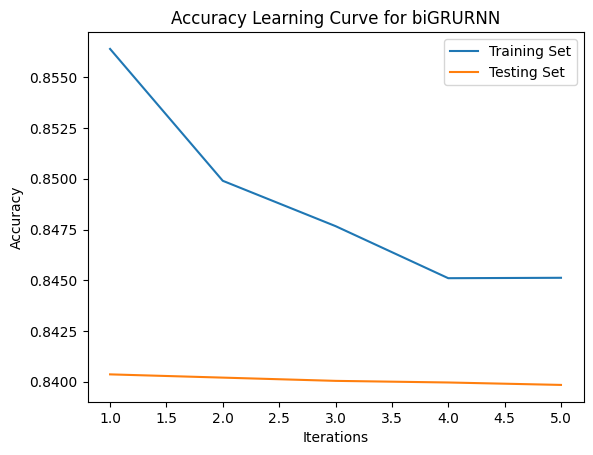

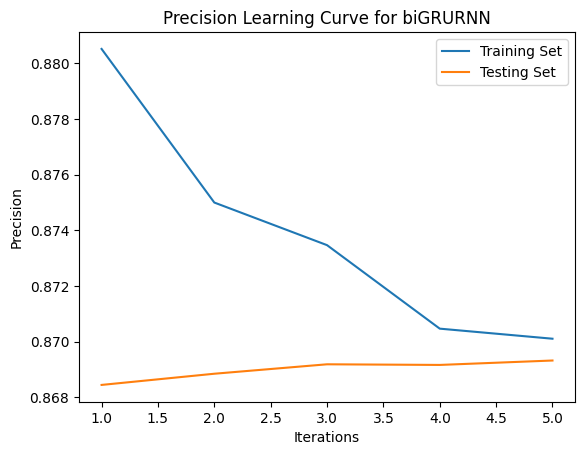

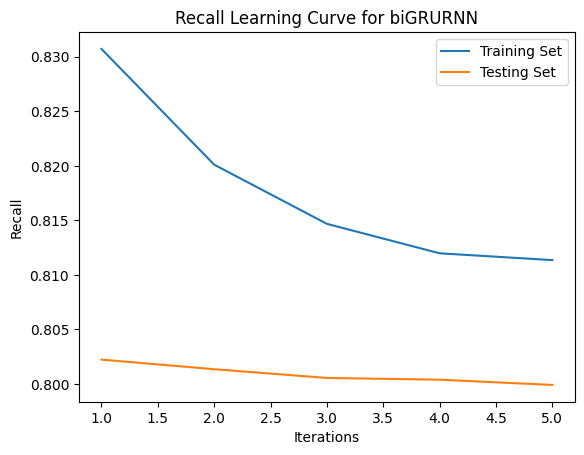

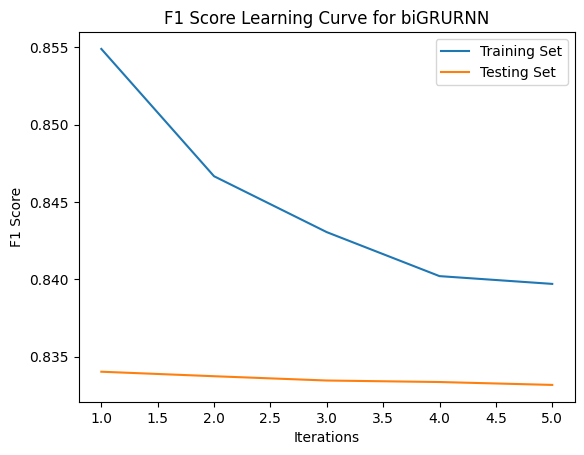

In [71]:
# Usage example for Custom Naive Bayes
nbc_learnig_curve = (
    training_accuracy_list_nbc, testing_accuracy_list_nbc,
    training_precision_list_nbc, testing_precision_list_nbc,
    training_recall_list_nbc, testing_recall_list_nbc,
    training_f1_list_nbc, testing_f1_list_nbc
) = learning_curve_for_biGRURNN(nbc, x_train_binary, y_train, x_test_binary, y_test, n_splits=5)


                        # 2a. Running BernoulliNB from Scikit-Learn

In [16]:
nb = BernoulliNB()
nb.fit(x_train_binary, y_train)
print("Classification report for Bernoulli Naive Bayes from sickit learn at trainig")
print(classification_report(y_train, nb.predict(x_train_binary),
                            zero_division=1))
print("Classification report for Bernoulli Naive Bayes from sickit learn at testing")
print(classification_report(y_test, nb.predict(x_test_binary),
                            zero_division=1))


Classification report for Bernoulli Naive Bayes from sickit learn at trainig
              precision    recall  f1-score   support

           0       0.87      0.85      0.86     12500
           1       0.85      0.88      0.86     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000

Classification report for Bernoulli Naive Bayes from sickit learn at testing
              precision    recall  f1-score   support

           0       0.86      0.84      0.85     12500
           1       0.85      0.86      0.86     12500

    accuracy                           0.85     25000
   macro avg       0.85      0.85      0.85     25000
weighted avg       0.85      0.85      0.85     25000



                        # 2b. Curves of BernoulliNB from Scikit-Learn

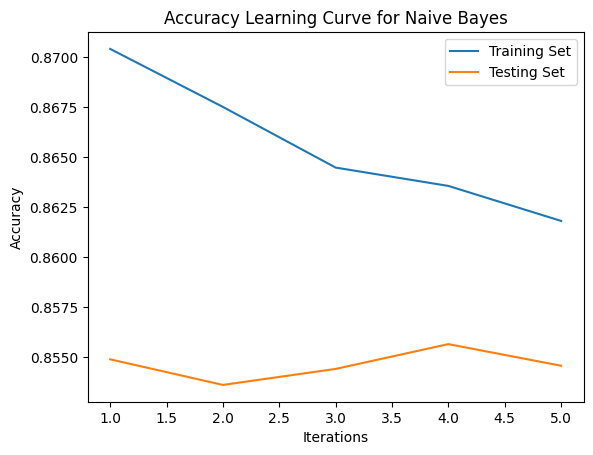

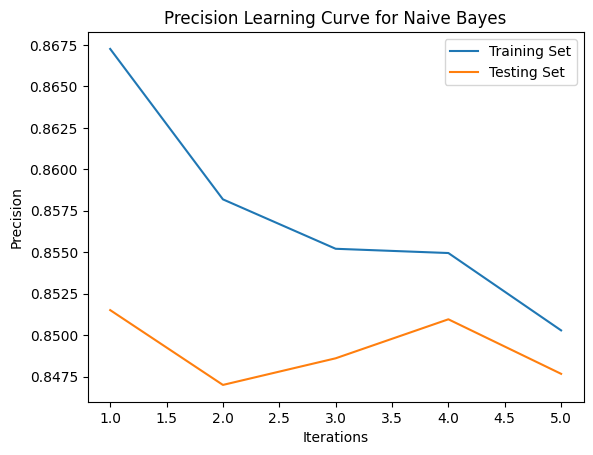

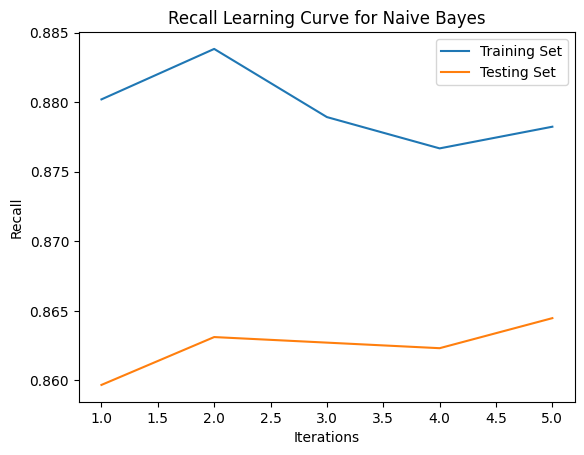

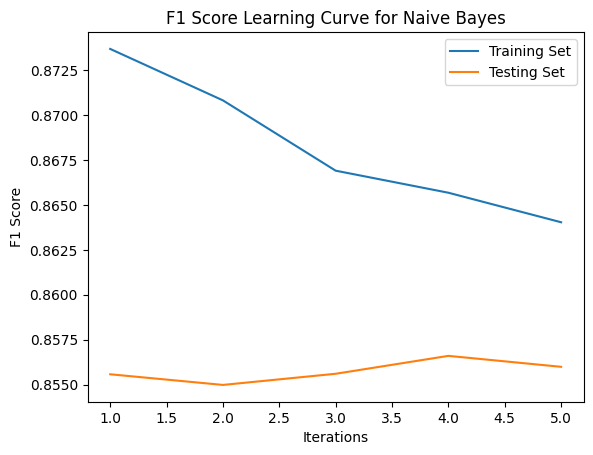

In [17]:
# Use learning_curves function for GaussianNB
nb_learning_curves = BernoulliNB()
(
    nb_training_accuracy_list, nb_testing_accuracy_list,
    nb_training_precision_list, nb_testing_precision_list,
    nb_training_recall_list, nb_testing_recall_list,
    nb_training_f1_list, nb_testing_f1_list
) = learning_curves(nb, x_train_binary, y_train, x_test_binary, y_test, n_splits=5)


                        # 3. Compare Custom Naive Bayes to BernoulliNB from Scikit-Learn 

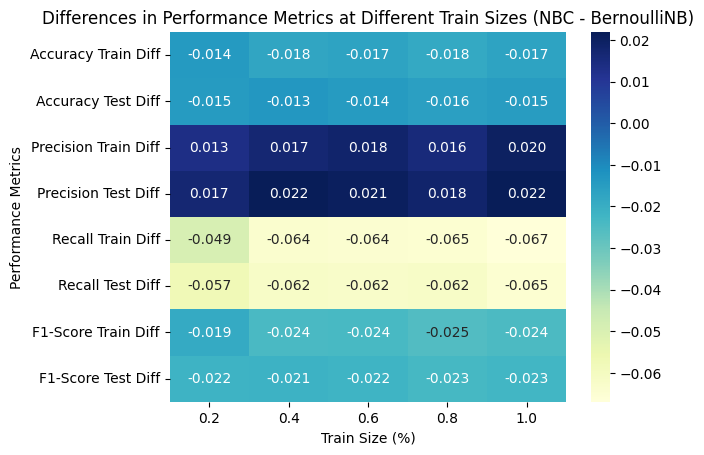

In [72]:
make_comparisons(
    (training_accuracy_list_nbc, testing_accuracy_list_nbc,
     training_precision_list_nbc, testing_precision_list_nbc,
     training_recall_list_nbc, testing_recall_list_nbc,
     training_f1_list_nbc, testing_f1_list_nbc),
    (nb_training_accuracy_list, nb_testing_accuracy_list,
     nb_training_precision_list, nb_testing_precision_list,
     nb_training_recall_list, nb_testing_recall_list,
     nb_training_f1_list, nb_testing_f1_list),
    train_sizes, n_splits=5
)

# Training And Testing Logistic Regression

                    # 1a. Running Custom Logistic Regresssion with SGA

Info: Hyperparameter learning rate (η) is considered fixed at 0.001 

In [19]:
# spliting training data to training and testing to find the best hyperparameters.
x_train_part, x_dev_part, y_train_part, y_dev_part = train_test_split(x_train_binary, y_train, test_size=0.1)

# Find best Logistic Regression Classifier (i.e. best regilarizer (λ factor)
best_instance, best_regularizer, best_acc = find_regularizer(x_train_part, x_dev_part, y_train_part, y_dev_part)
print("\n")
print('Best regularizer factor:\t', best_regularizer)
print('Best accuracy at development data accuracy:\t', best_acc)

	Regularizer:  0 	Devalopment Accuracy Score:  0.8724
	Regularizer:  1e-16 	Devalopment Accuracy Score:  0.8776
	Regularizer:  2e-16 	Devalopment Accuracy Score:  0.876
	Regularizer:  3e-16 	Devalopment Accuracy Score:  0.8748
	Regularizer:  4e-16 	Devalopment Accuracy Score:  0.8752
	Regularizer:  5e-16 	Devalopment Accuracy Score:  0.8784
	Regularizer:  6.000000000000001e-16 	Devalopment Accuracy Score:  0.8768
	Regularizer:  7.000000000000001e-16 	Devalopment Accuracy Score:  0.8768
	Regularizer:  8.000000000000002e-16 	Devalopment Accuracy Score:  0.8816
	Regularizer:  9.000000000000002e-16 	Devalopment Accuracy Score:  0.8744
	Regularizer:  1.0000000000000003e-15 	Devalopment Accuracy Score:  0.8752
	Regularizer:  1.1000000000000003e-15 	Devalopment Accuracy Score:  0.8712
	Regularizer:  1.2000000000000004e-15 	Devalopment Accuracy Score:  0.8728
	Regularizer:  1.3000000000000004e-15 	Devalopment Accuracy Score:  0.8752


Best regularizer factor:	 8.000000000000002e-16
Best accura

In [20]:
# # Find best Logistic Regression Classifier (i.e. best learning rate (η factor)
# best_instance, best_learning_rate, = find_learning_rate(x_train_part, x_dev_part, y_train_part, y_dev_part, best_regularizer )
# print("\n")
# print('Best learning rate factor:\t', best_learning_rate)
# print('Best accuracy at development data accuracy:\t', best_acc)

# clr = best_instance
# # Using Logistic Regression Classifier
# print(classification_report(y_test, clr.predict(x_test_binary)))

                    # 1b. Curves of Logistic Regresssion with SGA

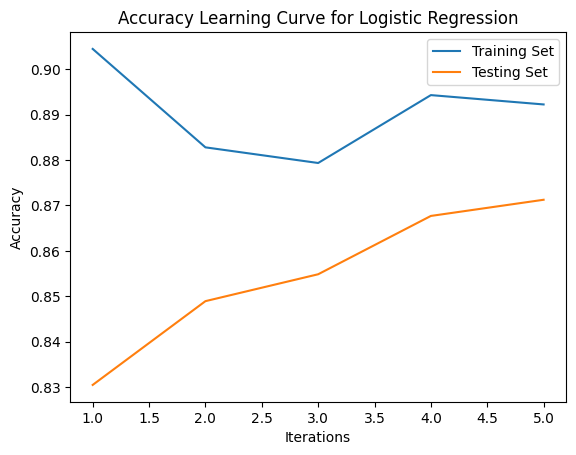

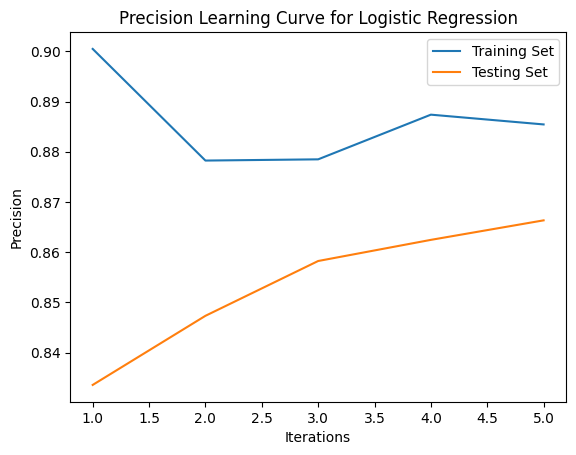

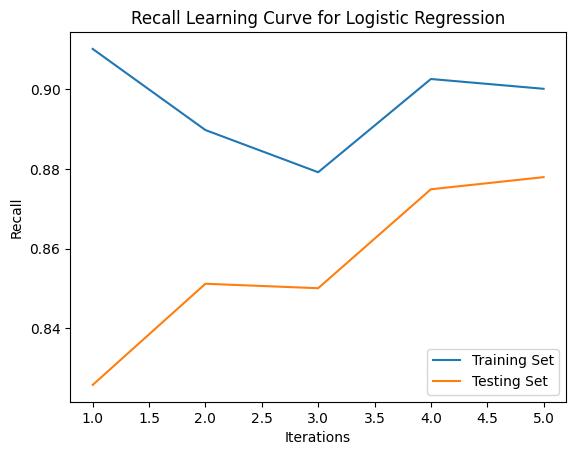

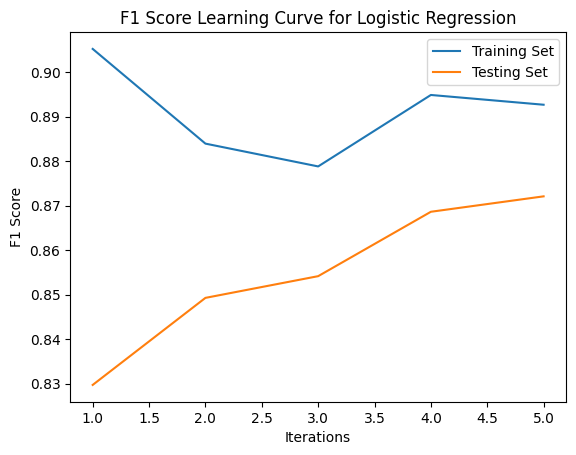

In [73]:
# Usage example for Logistic Regression
clr_learning_curve = (
    training_accuracy_list_clr, testing_accuracy_list_clr,
    training_precision_list_clr, testing_precision_list_clr,
    training_recall_list_clr, testing_recall_list_clr,
    training_f1_list_clr, testing_f1_list_clr
) = learning_curves(best_instance, x_train_part, y_train_part, x_test_binary, y_test, n_splits=5, counter=2)


                    # 2a. Running Logistic Regresssion from scikit-learn

In [22]:
#Algorithm to use in the optimization problem.
#Each solver tries to find the parameter weights that minimize a cost function
log = LogisticRegression()
log.fit(x_train_binary, y_train)

from sklearn.metrics import classification_report
print(classification_report(y_test, log.predict(x_test_binary)))

              precision    recall  f1-score   support

           0       0.88      0.86      0.87     12500
           1       0.87      0.88      0.87     12500

    accuracy                           0.87     25000
   macro avg       0.87      0.87      0.87     25000
weighted avg       0.87      0.87      0.87     25000



                    # 2b. Curves of Logistic Regresssion from scikit-learn

In [74]:
# Initialize Logistic Regression Classifier
# Usage example for Logistic Regression
lr_learning_curve = (
    LGtraining_accuracy_list, LGtesting_accuracy_list,
    LGtraining_precision_list, LGtesting_precision_list,
    LGtraining_recall_list, LGtesting_recall_list,
    LGtraining_f1_list, LGtesting_f1_list
) = learning_curves(log, x_train_binary, y_train, x_test_binary, y_test, n_splits=5, counter=2)

                        # 3. Compare Custom Logistic Regression to Logistic Regression from Scikit-Learn 

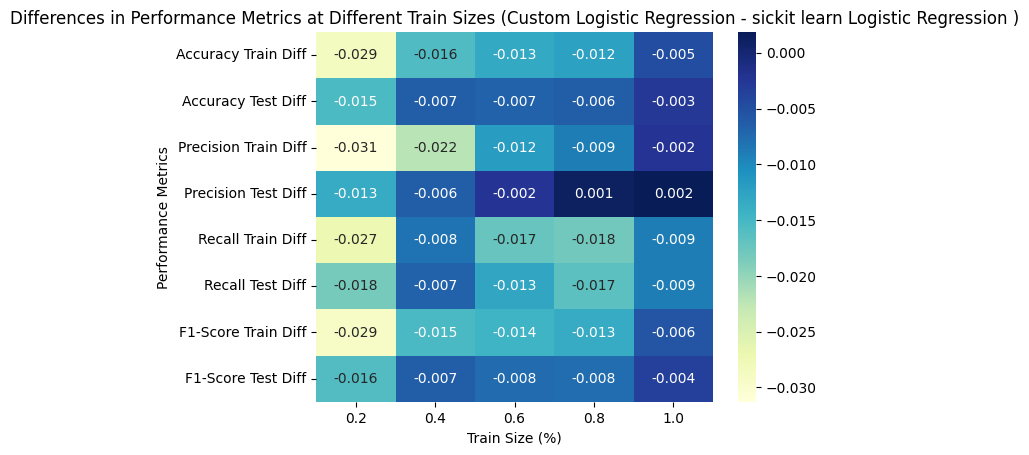

In [24]:

make_comparisons(
    (training_accuracy_list_clr, testing_accuracy_list_clr,
    training_precision_list_clr, testing_precision_list_clr,
    training_recall_list_clr, testing_recall_list_clr,
    training_f1_list_clr, testing_f1_list_clr
    ),
    (LGtraining_accuracy_list, LGtesting_accuracy_list,
    LGtraining_precision_list, LGtesting_precision_list,
    LGtraining_recall_list, LGtesting_recall_list,
    LGtraining_f1_list, LGtesting_f1_list),
    train_sizes, n_splits=5, counter=2
)

EKREMMOTHTES:
2. NA TSEKAROUME TA COMMENTS APO CHAT-GPT
3. NA PROSTHESOUME TA EPIPLEON DIAGRAMS (AN XREIASTEI)


## Part C

In [32]:
class RNN:

  def __init__(self, vectorizer,emb_size,h_size, num_layers, epochs=1, verbose=1, batch_size=32, embedding_matrix=None):
    self.vectorizer = vectorizer
    self.emb_size = emb_size
    self.h_size = h_size
    self.num_layers = num_layers
    self.embedding_matrix = embedding_matrix
    self.epochs = epochs
    self.verbose = verbose
    self.batch_size = batch_size

    # self.imdb_bigru = self.get_bigru()
    # self.imdb_bigru.compile(loss=tf.keras.losses.BinaryCrossentropy(), optimizer=tf.keras.optimizers.Adam(), metrics=['binary_accuracy'])
    
  def get_bigru(self):
    inputs = tf.keras.layers.Input(shape=(1,), dtype=tf.string, name='txt_input')
    x = vectorizer(inputs)
    x = tf.keras.layers.Embedding(input_dim=len(vectorizer.get_vocabulary()),
                                  output_dim=self.emb_size, name='word_embeddings',
                                  mask_zero=True)(x)
    for n in range(self.num_layers):
      if n != self.num_layers - 1:
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.h_size, 
                                name=f'bigru_cell_{n}', 
                                return_sequences=True,
                                dropout=0.2))(x)
      else:
        x = tf.keras.layers.Bidirectional(tf.keras.layers.GRU(units=self.h_size, 
                                          name=f'bigru_cell_{n}',
                                          dropout=0.2))(x)

    x = tf.keras.layers.Dropout(rate=0.5)(x)
    o = tf.keras.layers.Dense(units=1, activation='sigmoid', name='lr')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=o, name='simple_rnn')
  
  def fit(self, x_train_b, y_train_b):
    self.imdb_bigru = self.get_bigru()
    self.imdb_bigru.compile(loss=tf.keras.losses.BinaryCrossentropy(), 
                            optimizer=tf.keras.optimizers.legacy.Adam(),
                            metrics=[tf.keras.metrics.BinaryAccuracy(),
                                    tf.keras.metrics.Precision(),
                                    tf.keras.metrics.Recall()])
    
    self.imdb_bigru.fit(x= x_train_b, y=y_train_b, epochs=self.epochs, verbose=self.verbose, batch_size=self.batch_size)

  def predict(self, x_test_b):
    return np.round(self.imdb_bigru.predict(x_test_b))


### RNN or MLP me kyliomeno parathyro

In [33]:
# Estimating the sequence (example review) length (average length of all reviews in training data)
import statistics
sample = []
for example in tqdm(x_train):
  tokens = str(example).split()
  sample.append(len(tokens))

print(math.ceil(statistics.mean(sample) + 2.581 * statistics.stdev(sample)/math.sqrt(len(sample))))    # 99% confidence interval

  0%|          | 0/25000 [00:00<?, ?it/s]

100%|██████████| 25000/25000 [00:00<00:00, 29867.96it/s]

242


In [34]:
# Embedding layer creates word embeddings by mapping integer encoded sequences to dense vectors, 
# so we first convert the examples (sequences) to integer vectors

SEQ_MAX_LENGTH = 245
vectorizer = tf.keras.layers.TextVectorization(output_mode='int', 
                                               ngrams=1, name='vector_text',
                                               output_sequence_length=SEQ_MAX_LENGTH,
                                               vocabulary=list(vocabulary.keys()))


In [46]:
def learning_curve(predictor, x_train, y_train, x_test, y_test, n_splits):
  

  def append(scores): 
    y_pred_train = pred.predict(curr_x_train_part)        # validation data is excluded, only training data considered
    y_pred_test = pred.predict(x_test)

    for f in scores:
      f[1].append(f[0](curr_y_train_part, y_pred_train))  # validation data is excluded, only training data considered
      f[2].append(f[0](y_test, y_pred_test))

    splits.append(len(curr_x_train_part))
    

  def plotter(scores):
    fig, axs = plt.subplots(4, 2, figsize=(10, 17))      

    i = pred.__str__().find("(")
    suptitle = pred.__str__()[:i]
    fig.suptitle(suptitle, size="25")

    subplots = [ax for ax in axs.flat]
    for i in range(0, len(subplots), 2):
        f = scores[i//2]

        subplot = subplots[i]       # 1st subplot of metric f, zoomed in
        l1 = subplot.plot(splits, f[1], 'o-', color="royalblue", label="Training")
        l2 = subplot.plot(splits, f[2], '-', color="crimson", label="Testing")
        subplot.grid()
        subplot.set_xticks(splits, splits)
        subplot.set_title(f[0].__name__.replace("_", " ").capitalize(), loc='left', style='italic', bbox = dict(facecolor = 'white', boxstyle="round"))

        subplot = subplots[i+1]     # 2nd subplot of metric f, zoomed out  (specified range of y axis)
        l1 = subplot.plot(splits, f[1], 'o-', color="royalblue", label="Training")
        l2 = subplot.plot(splits, f[2], '-', color="crimson", label="Testing")
        subplot.grid()
        subplot.set_xticks(splits, splits)
        subplot.set_ylim(0, 1)
  
    fig.legend([l1, l2], labels=["Training", "Testing"],loc="upper right")
    fig.supxlabel("Training Set Size")
    fig.supylabel("Metrics score")
    plt.subplots_adjust(right=0.9)
    plt.show()



  pred = predictor

  split_size = int(len(x_train) / n_splits)
  x_splits = np.split(x_train, n_splits) # must be equal division
  y_splits = np.split(y_train, n_splits)

  splits = list()
  train_accuracy, test_accuracy = list(), list()
  train_precision, test_presicion = list(), list()
  train_recall, test_recall = list(), list()
  train_f1, test_f1 = list(), list()

  scores = [(accuracy_score,train_accuracy, test_accuracy), 
      (precision_score, train_precision, test_presicion),
      (recall_score, train_recall, test_recall),
      (f1_score, train_f1, test_f1)
    ]

  curr_x = x_splits[0]
  curr_y = y_splits[0]

  if type(predictor) is CustomLogisticRegression:             # the only classifier to be using validation data is our CustomLogisticRegression (early stopping), 
    curr_x_train_part, curr_y_train_part = pred.fit(curr_x, curr_y) # so in this case only the part of data actually used as training data should be considered as "training data"
  else:
    pred.fit(curr_x, curr_y)
    curr_x_train_part = curr_x
    curr_y_train_part = curr_y

  append(scores)  #predict then append

  for i in tqdm(range(1, len(x_splits))):

    pred = predictor

    curr_x = np.concatenate((curr_x, x_splits[i]), axis=0)
    curr_y = np.concatenate((curr_y, y_splits[i]), axis=0)

    if type(predictor) is CustomLogisticRegression:             # the only classifier to be using validation data is our CustomLogisticRegression (early stopping), 
      curr_x_train_part, curr_y_train_part = pred.fit(curr_x, curr_y) # so in this case only the part of data actually used as training data should be considered as "training data"
    else:
      curr_x_train_part = curr_x
      curr_y_train_part = curr_y
      pred.fit(curr_x, curr_y)
      

    append(scores) #predict then append
  
  # Show reporting table
  report_table = pd.DataFrame([x/len(x_train)*100 for x in splits], columns= ["Train Size (%)"]).set_index("Train Size (%)")
  report_table['Accuracy Train'] = train_accuracy
  report_table['Accuracy Test'] = test_accuracy
  report_table['Precision Train'] = train_precision
  report_table['Precision Test'] = test_presicion
  report_table['Recall Train'] = train_recall
  report_table['Recall Test'] = test_recall
  report_table['F1 Train'] = train_f1
  report_table['F1 Test'] = test_f1
  display(report_table)

  # Show reporting plots
  plotter(scores)
  return report_table

In [41]:
# Training RNN
rnn = RNN(vectorizer=vectorizer,  emb_size=64, h_size=64,num_layers=1, epochs=1, verbose=1, batch_size=32)
rnn.fit(x_train_b=x_train, y_train_b=y_train)

# plot_model(rnn.imdb_bigru, to_file='model.png', show_shapes=True)
# Image('model.png')

# Using RNN
y_pred = rnn.predict(x_test_b = x_test)
print(classification_report(y_test, y_pred))

782/782 [==============================] - 39s 47ms/step
              precision    recall  f1-score   support

           0       0.88      0.79      0.84     12500
           1       0.81      0.90      0.85     12500

    accuracy                           0.84     25000
   macro avg       0.85      0.84      0.84     25000
weighted avg       0.85      0.84      0.84     25000



Calculating Metrics:   0%|          | 0/5 [00:00<?, ?it/s]

782/782 [==============================] - 21s 27ms/step


Calculating Metrics:  20%|██        | 1/5 [01:06<04:26, 66.69s/it]

782/782 [==============================] - 26s 33ms/step


Calculating Metrics:  40%|████      | 2/5 [02:28<03:46, 75.53s/it]

782/782 [==============================] - 26s 33ms/step


Calculating Metrics:  60%|██████    | 3/5 [04:28<03:11, 95.76s/it]

782/782 [==============================] - 24s 28ms/step


Calculating Metrics:  80%|████████  | 4/5 [06:17<01:41, 101.11s/it]

782/782 [==============================] - 20s 25ms/step


Calculating Metrics: 100%|██████████| 5/5 [08:34<00:00, 102.88s/it]


,Accuracy Train,Accuracy Test,Precision Train,Precision Test,Recall Train,Recall Test,F1 Train,F1 Test
Train Size (%),,,,,,,,
20.0,0.617,0.580,0.809,0.698,0.325,0.282,0.464,0.402
40.0,0.840,0.821,0.852,0.835,0.826,0.799,0.839,0.817
60.0,0.845,0.830,0.848,0.836,0.843,0.821,0.845,0.828
80.0,0.860,0.848,0.832,0.823,0.903,0.886,0.866,0.854
100.0,0.854,0.843,0.809,0.800,0.926,0.916,0.864,0.854


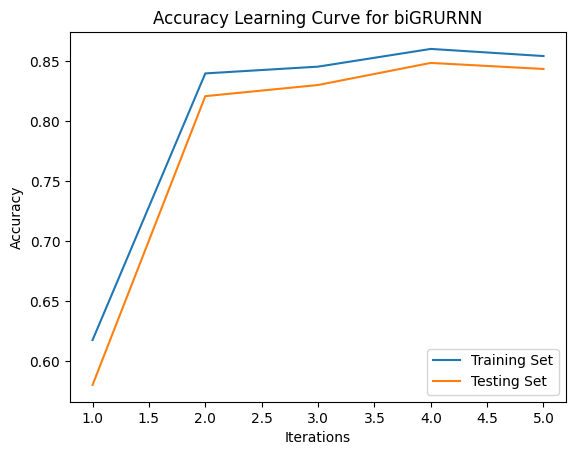

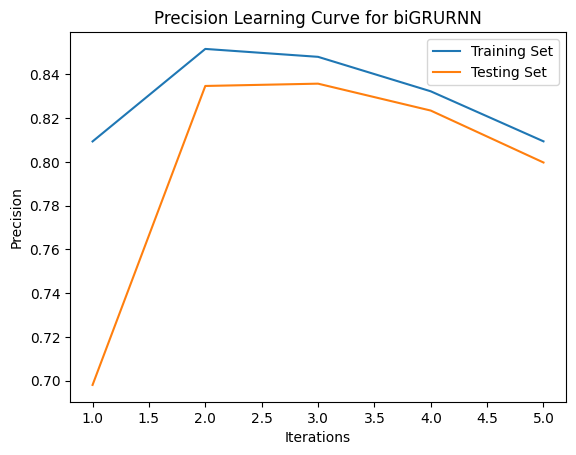

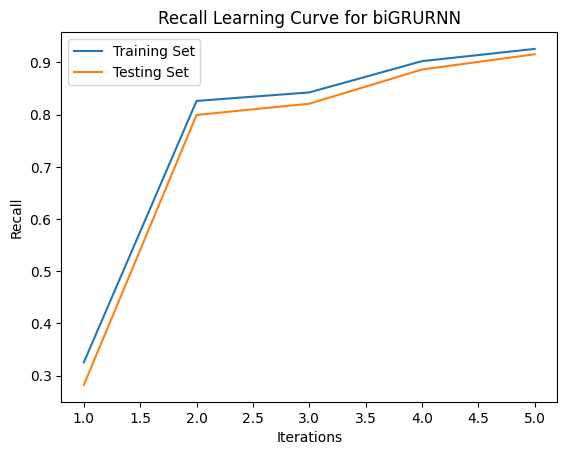

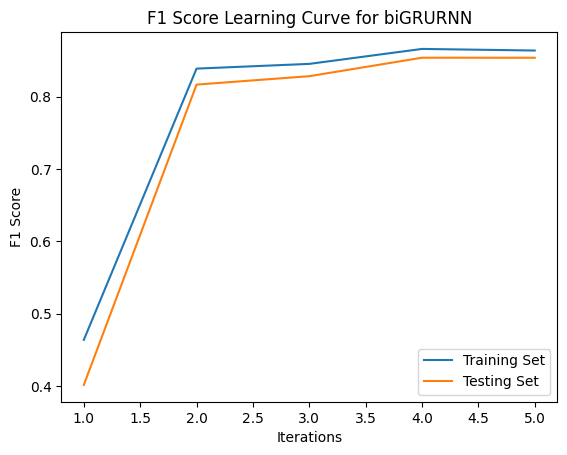

In [64]:
# Curves of RNN 
rnn = RNN(vectorizer=vectorizer,  emb_size=64, h_size=64,num_layers=1, epochs=1, verbose=1, batch_size=32)
# report_BiGRU_RNN = learning_curves(rnn, x_train,y_train, x_test, y_test, n_splits=5)
report_BiGRU_RNN = (training_accuracy_list_rnn, testing_accuracy_list_rnn,
     training_precision_list_rnn, testing_precision_list_rnn,
     training_recall_list_rnn, testing_recall_list_rnn,
     training_f1_list_rnn, testing_f1_list_rnn)= learning_curve_for_biGRURNN(rnn, x_train,y_train, x_test, y_test, n_splits=5)

In [ ]:
# rnn = RNN(vectorizer=vectorizer,  emb_size=64, h_size=64,num_layers=1, epochs=1, verbose=1, batch_size=32)
# # report_BiGRU_RNN = learning_curves(rnn, x_train,y_train, x_test, y_test, n_splits=5)
# report_BiGRU_RNN = learning_curve(rnn, x_train,y_train, x_test, y_test, n_splits=5)

In [65]:
# Loss curves of RNN
rnn = RNN(vectorizer=vectorizer,  emb_size=64, h_size=64,num_layers=1, epochs=1, verbose=1, batch_size=32)
this = rnn.fit(x_train, y_train)

loss_plot(this)

782/782 [==============================] - 77s 94ms/step - loss: 0.5126 - binary_accuracy: 0.7217 - precision_41: 0.7187 - recall_41: 0.7286


AttributeError: 'NoneType' object has no attribute 'history'

## Part C: Comparisons

####  Naive Bayes vs RNN

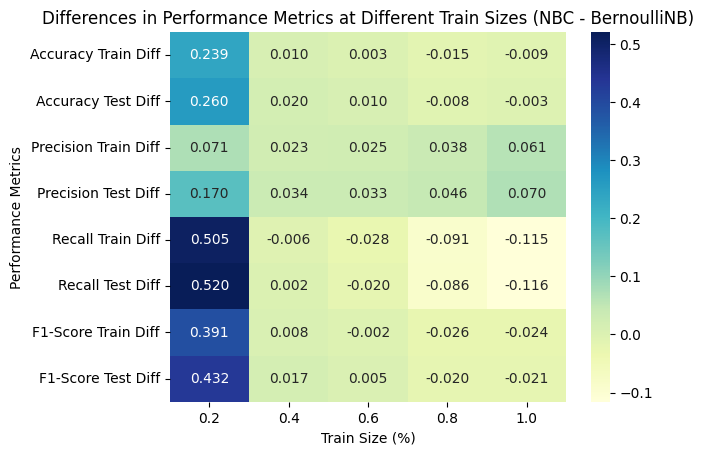

In [67]:
make_comparisons(
    (
    training_accuracy_list_nbc, testing_accuracy_list_nbc,
    training_precision_list_nbc, testing_precision_list_nbc,
    training_recall_list_nbc, testing_recall_list_nbc,
    training_f1_list_nbc, testing_f1_list_nbc
    ),
    (training_accuracy_list_rnn, testing_accuracy_list_rnn,
     training_precision_list_rnn, testing_precision_list_rnn,
     training_recall_list_rnn, testing_recall_list_rnn,
     training_f1_list_rnn, testing_f1_list_rnn),
    train_sizes, n_splits=5
)

#### Logistic Regression vs RNN 

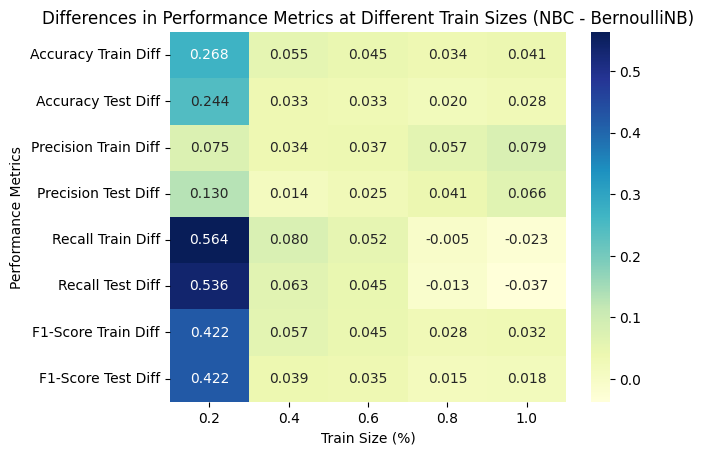

In [69]:
make_comparisons(
    (
    training_accuracy_list_clr, testing_accuracy_list_clr,
    training_precision_list_clr, testing_precision_list_clr,
    training_recall_list_clr, testing_recall_list_clr,
    training_f1_list_clr, testing_f1_list_clr
    ),
    (training_accuracy_list_rnn, testing_accuracy_list_rnn,
     training_precision_list_rnn, testing_precision_list_rnn,
     training_recall_list_rnn, testing_recall_list_rnn,
     training_f1_list_rnn, testing_f1_list_rnn),
    train_sizes, n_splits=5
)

ekkremotites:
1) na ftiaksoume to history gia to loss_plot (thelei i fit toy rnn na kanei kati return, to exoyn ta paidia)